# Introduction

This demo uses mask-RCNN to accomplish the image processing. Input an original image (suppose this image include a person or some people), this program will recognize the main character and save him/her as RGB image while other background information will be changed as grayscale. 

Here are some demo images:

|**Original Image 1**|**New Image 1**|**Original Image 2**|**New Image 2**|
| :--: | :--: | :--: | :--: |
|![](demo/14.jpg)|![](demo/14N.jpg)|![](demo/1.jpg)|![](demo/1N.jpg)|

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
!git clone https://github.com/huuuuusy/Mask-RCNN-Shiny.git

Cloning into 'Mask-RCNN-Shiny'...
remote: Enumerating objects: 82, done.
remote: Total 82 (delta 0), reused 0 (delta 0), pack-reused 82
Unpacking objects: 100% (82/82), done.


In [3]:
import os
os.chdir('Mask-RCNN-Shiny')

In [4]:
import cv2
import numpy as np
# import os
import sys
from samples import coco
from mrcnn import utils
from mrcnn import model as modellib
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Prepare Image

First, load the original image from disk and show it in window by using OpenCV.

In [13]:
# Input the original image name
original_image = 'frame110.jpg'

In [34]:
# Use OpenCV to read and show the original image
image = cv2.imread(original_image)
# cv2.imshow('original_image', image)

# print("Read original image successfully! The original image shape is:")
height, width, channels = image.shape
print(image.shape)

# print("Press ESC to exit or press s to save and exit.")

# Wait for keys to exit or save
# k = cv2.waitKey(0)
# if k == 27:                 
#     cv2.destroyAllWindows()
# elif k == ord('s'):        
#     cv2.imwrite('original_image.jpg', image)
#     cv2.destroyAllWindows()

(646, 604, 3)


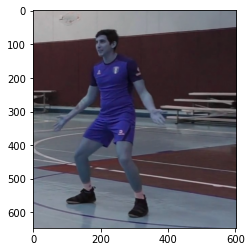

In [35]:
imgplot = plt.imshow(image)
plt.show()

Next, use cvtColor to accomplish image transformation from RGB image to gray image.

**Attention: the original image is an colorful image which has 3 channels(RGB), while the gray image is a grayscale, which only has 2D format.**

In [36]:
# Use cvtColor to accomplish image transformation from RGB image to gray image
size=(height,width)
gray_image=np.zeros(size)
# gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# cv2.imshow('gray_image', gray_image)

# print("Change gray image successfully! The gray image shape is:")
print(gray_image.shape)
# print("Press ESC to exit or press s to save and exit.")

# Wait for keys to exit or save
# k = cv2.waitKey(0)
# if k == 27:                 
#     cv2.destroyAllWindows()
# elif k == ord('s'):        
#     cv2.imwrite('gray_image.jpg', image)
#     cv2.destroyAllWindows()

(646, 604)


# Prepare Model File and Configuration Information

Now load the pre-trained model data (Mask-RCNN trained by COCO dataset).

In [20]:
# Load the pre-trained model data
ROOT_DIR = os.getcwd()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


The original configuration information is saved in config.py file. It can be changed if necessary. 

It's better to use the default value, but you can also change the GPU information to suit the personal GPU well.

In [21]:
# Change the config infermation
class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    
    # Number of images to train with on each GPU. A 12GB GPU can typically
    # handle 2 images of 1024x1024px.
    # Adjust based on your GPU memory and image sizes. Use the highest
    # number that your GPU can handle for best performance.
    IMAGES_PER_GPU = 1
    
config = InferenceConfig()

In [22]:
# COCO dataset object names
model = modellib.MaskRCNN(
    mode="inference", model_dir=MODEL_DIR, config=config
)
model.load_weights(COCO_MODEL_PATH, by_name=True)
class_names = [
    'BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
    'bus', 'train', 'truck', 'boat', 'traffic light',
    'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
    'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
    'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
    'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
    'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
    'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
    'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
    'teddy bear', 'hair drier', 'toothbrush'
]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


# Define The Image Process Function

Now define two image process functions. 

apply_mask is used to change the background information to grayscale.

display_instances is used to show the object detection result in original image.

In [23]:
# This function is used to change the colorful background information to grayscale.
# image[:,:,0] is the Blue channel,image[:,:,1] is the Green channel, image[:,:,2] is the Red channel
# mask == 0 means that this pixel is not belong to the object.
# np.where function means that if the pixel belong to background, change it to gray_image.
# Since the gray_image is 2D, for each pixel in background, we should set 3 channels to the same value to keep the grayscale.

def apply_mask(image, mask):
    image[:, :, 0] = np.where(
        mask == 0,
        gray_image[:, :],
        image[:, :, 0]
    )
    image[:, :, 1] = np.where(
        mask == 0,
        gray_image[:, :],
        image[:, :, 1]
    )
    image[:, :, 2] = np.where(
        mask == 0,
        gray_image[:, :],
        image[:, :, 2]
    )
    return image

In [24]:
# This function is used to show the object detection result in original image.
def display_instances(image, boxes, masks, ids, names, scores):
    # max_area will save the largest object for all the detection results
    max_area = 0
    
    # n_instances saves the amount of all objects
    n_instances = boxes.shape[0]

    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]

    for i in range(n_instances):
        if not np.any(boxes[i]):
            continue

        # compute the square of each object
        y1, x1, y2, x2 = boxes[i]
        square = (y2 - y1) * (x2 - x1)

        # use label to select person object from all the 80 classes in COCO dataset
        label = names[ids[i]]
        if label == 'person':
            # save the largest object in the image as main character
            # other people will be regarded as background
            if square > max_area:
                max_area = square
                mask = masks[:, :, i]
            else:
                continue
        else:
            continue

        # apply mask for the image
    # by mistake you put apply_mask inside for loop or you can write continue in if also
    image = apply_mask(image, mask)
        
    return image

# Process Image

Now use the functions above to accomplish the image processing and save the result.

In [37]:
results = model.detect([image], verbose=0)
r = results[0]
frame = display_instances(
    image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores']
)
# cv2.imshow('save_image', frame)
# os.chdir(r'./drive/MyDrive/VISION ARTIFICIAL')

# Wait for keys to exit or save
# k = cv2.waitKey(0)
# if k == 27:                 
#     cv2.destroyAllWindows()
# elif k == ord('s'):        
#     name='save_image.jpg'
#     cv2.imwrite(name, image)
#     cv2.destroyAllWindows()

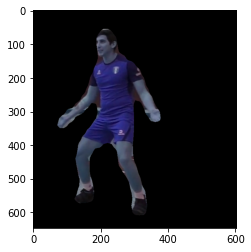

In [38]:
imgplot = plt.imshow(image)
plt.show()